# Loading the necessary packages

In [1]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras import backend

* Autoencoders are a class of Unsupervised Networks that consist of two major networks: Encoders and Decoders.

* An Unsupervised Network is a network that learns patterns from data without any training labels. The network finds its patterns in the data without being told what the patterns should be.

* In contrast, there are Supervised Networks wherein the network is trained to return specific outputs when given specific inputs.

* The Encoder generally uses a series of Dense and/or Convolutional layers to encode an image into a fixed length vector that represents the image a compact form, while the Decoder uses Dense and/or Convolutional layers to convert the latent representation vector back into that same image or another modified image.

* To generate an image, a random input vector is given to the Decoder network. The Decoder network will convert the input vector into a full image.

# Loading the MNIST data

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

* The **np.expand_dims function** is used to add an additional dimension to an array. In the context of the provided code snippet, it is used to add a channel dimension to the training and test datasets, converting them from 3D arrays (height, width, grayscale) to 4D arrays (batch size, height, width, channels). This is important when working with convolutional neural networks (CNNs) in frameworks like TensorFlow and Keras, which expect the input data to have a specific shape.
  
* np.expand_dims(x_train, axis=-1) adds a new dimension at the end of the shape, converting (60000, 28, 28) to (60000, 28, 28, 1).
  
* The value for axis in **np.expand_dims** is given as **-1** to specify that the new dimension should be added at the end of the array's shape. In NumPy, the axis parameter can be a positive integer or a negative integer. When it's a positive integer, it counts the axes from the beginning (starting at 0). When it's a negative integer, it counts the axes from the end (starting at -1).

# Adding random noise to the dataset

In [3]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

* **np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)** generates an array of random values drawn from a normal (Gaussian) distribution.
  
* **loc=0.0:** This specifies the **mean of the Gaussian distribution**, which is 0 in this case.
  
* **scale=1.0:** This specifies the **standard deviation of the Gaussian distribution**, which is 1 in this case.

* **size=x_train.shape:** This specifies the shape of the output array to be the same as x_train. Essentially, it creates a noise array that has the same dimensions as the training data.

# Creating the AutoEncoder Model

In [4]:
input_shape = (28, 28, 1)
latent_dim = 128

## Encoder

In [5]:
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(inputs)
x = Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x)

In [6]:
shape_before_bottleneck = backend.int_shape(x)[1:]

* **shape_before_bottleneck = backend.int_shape(x)[1:]** This slice operation removes the first element of the tuple, which corresponds to the batch size.

* The resulting shape is (height, width, channels), which are the dimensions of each sample in the batch, excluding the batch dimension.

In [7]:
x = Flatten()(x)
latent_repr = Dense(latent_dim)(x)

## Decoder

In [8]:
x = Dense(np.prod(shape_before_bottleneck))(latent_repr)
x = Reshape(shape_before_bottleneck)(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
decoded = Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same')(x)

## Combining the encoder and the decoder

In [9]:
autoencoder = Model(inputs, decoded)

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               401536    
                                                                 
 dense_1 (Dense)             (None, 3136)              404544    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0     

# Compiling the model

In [11]:
autoencoder.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

# Adding Earlystopping to prevent overfitting

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the Autoencoder model

In [13]:
history = autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
938/938 [==============================] - 6s 6ms/step - loss: 0.2295 - accuracy: 0.7984 - val_loss: 0.1410 - val_accuracy: 0.8068
Epoch 2/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1265 - accuracy: 0.8093 - val_loss: 0.1148 - val_accuracy: 0.8100
Epoch 3/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1110 - accuracy: 0.8117 - val_loss: 0.1059 - val_accuracy: 0.8114
Epoch 4/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1045 - accuracy: 0.8126 - val_loss: 0.1016 - val_accuracy: 0.8118
Epoch 5/100
938/938 [==============================] - 5s 6ms/step - loss: 0.1010 - accuracy: 0.8130 - val_loss: 0.0992 - val_accuracy: 0.8121
Epoch 6/100
938/938 [==============================] - 5s 6ms/step - loss: 0.0988 - accuracy: 0.8133 - val_loss: 0.0977 - val_accuracy: 0.8124
Epoch 7/100
938/938 [==============================] - 5s 6ms/step - loss: 0.0973 - accuracy: 0.8134 - val_loss: 0.0966 - val_accuracy: 0.8126

# Displaying the results

In [14]:
denoised_test_images = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 1s 1ms/step


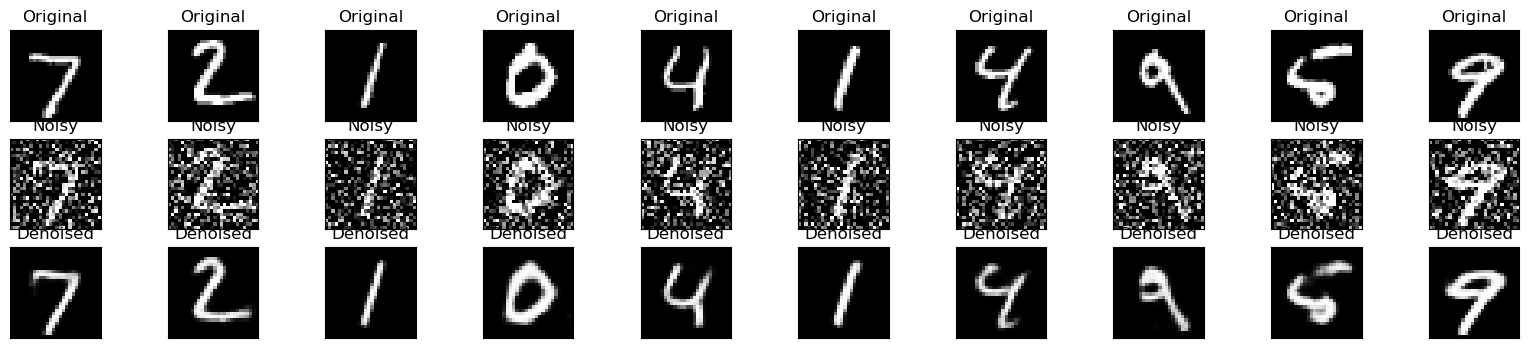

In [15]:
# Displaying original, noisy, and denoised images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(denoised_test_images[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

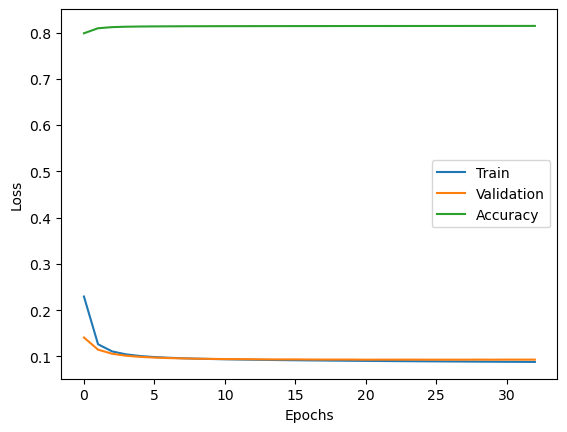

In [16]:
def plotloss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()

plotloss(history)

In [17]:
#Checking the model accuracy
evaluation = autoencoder.evaluate(x_test_noisy, x_test)
evaluation[1]

313/313 [==============================] - 1s 2ms/step - loss: 0.0931 - accuracy: 0.8129


0.8129215240478516